# Drought Prediction Using Machine Learning

In this Jupyter notebook you will see the process I used to train a machine learning model to predict droughts. I connected my completed model to a website in order to visualize the data as seen here:


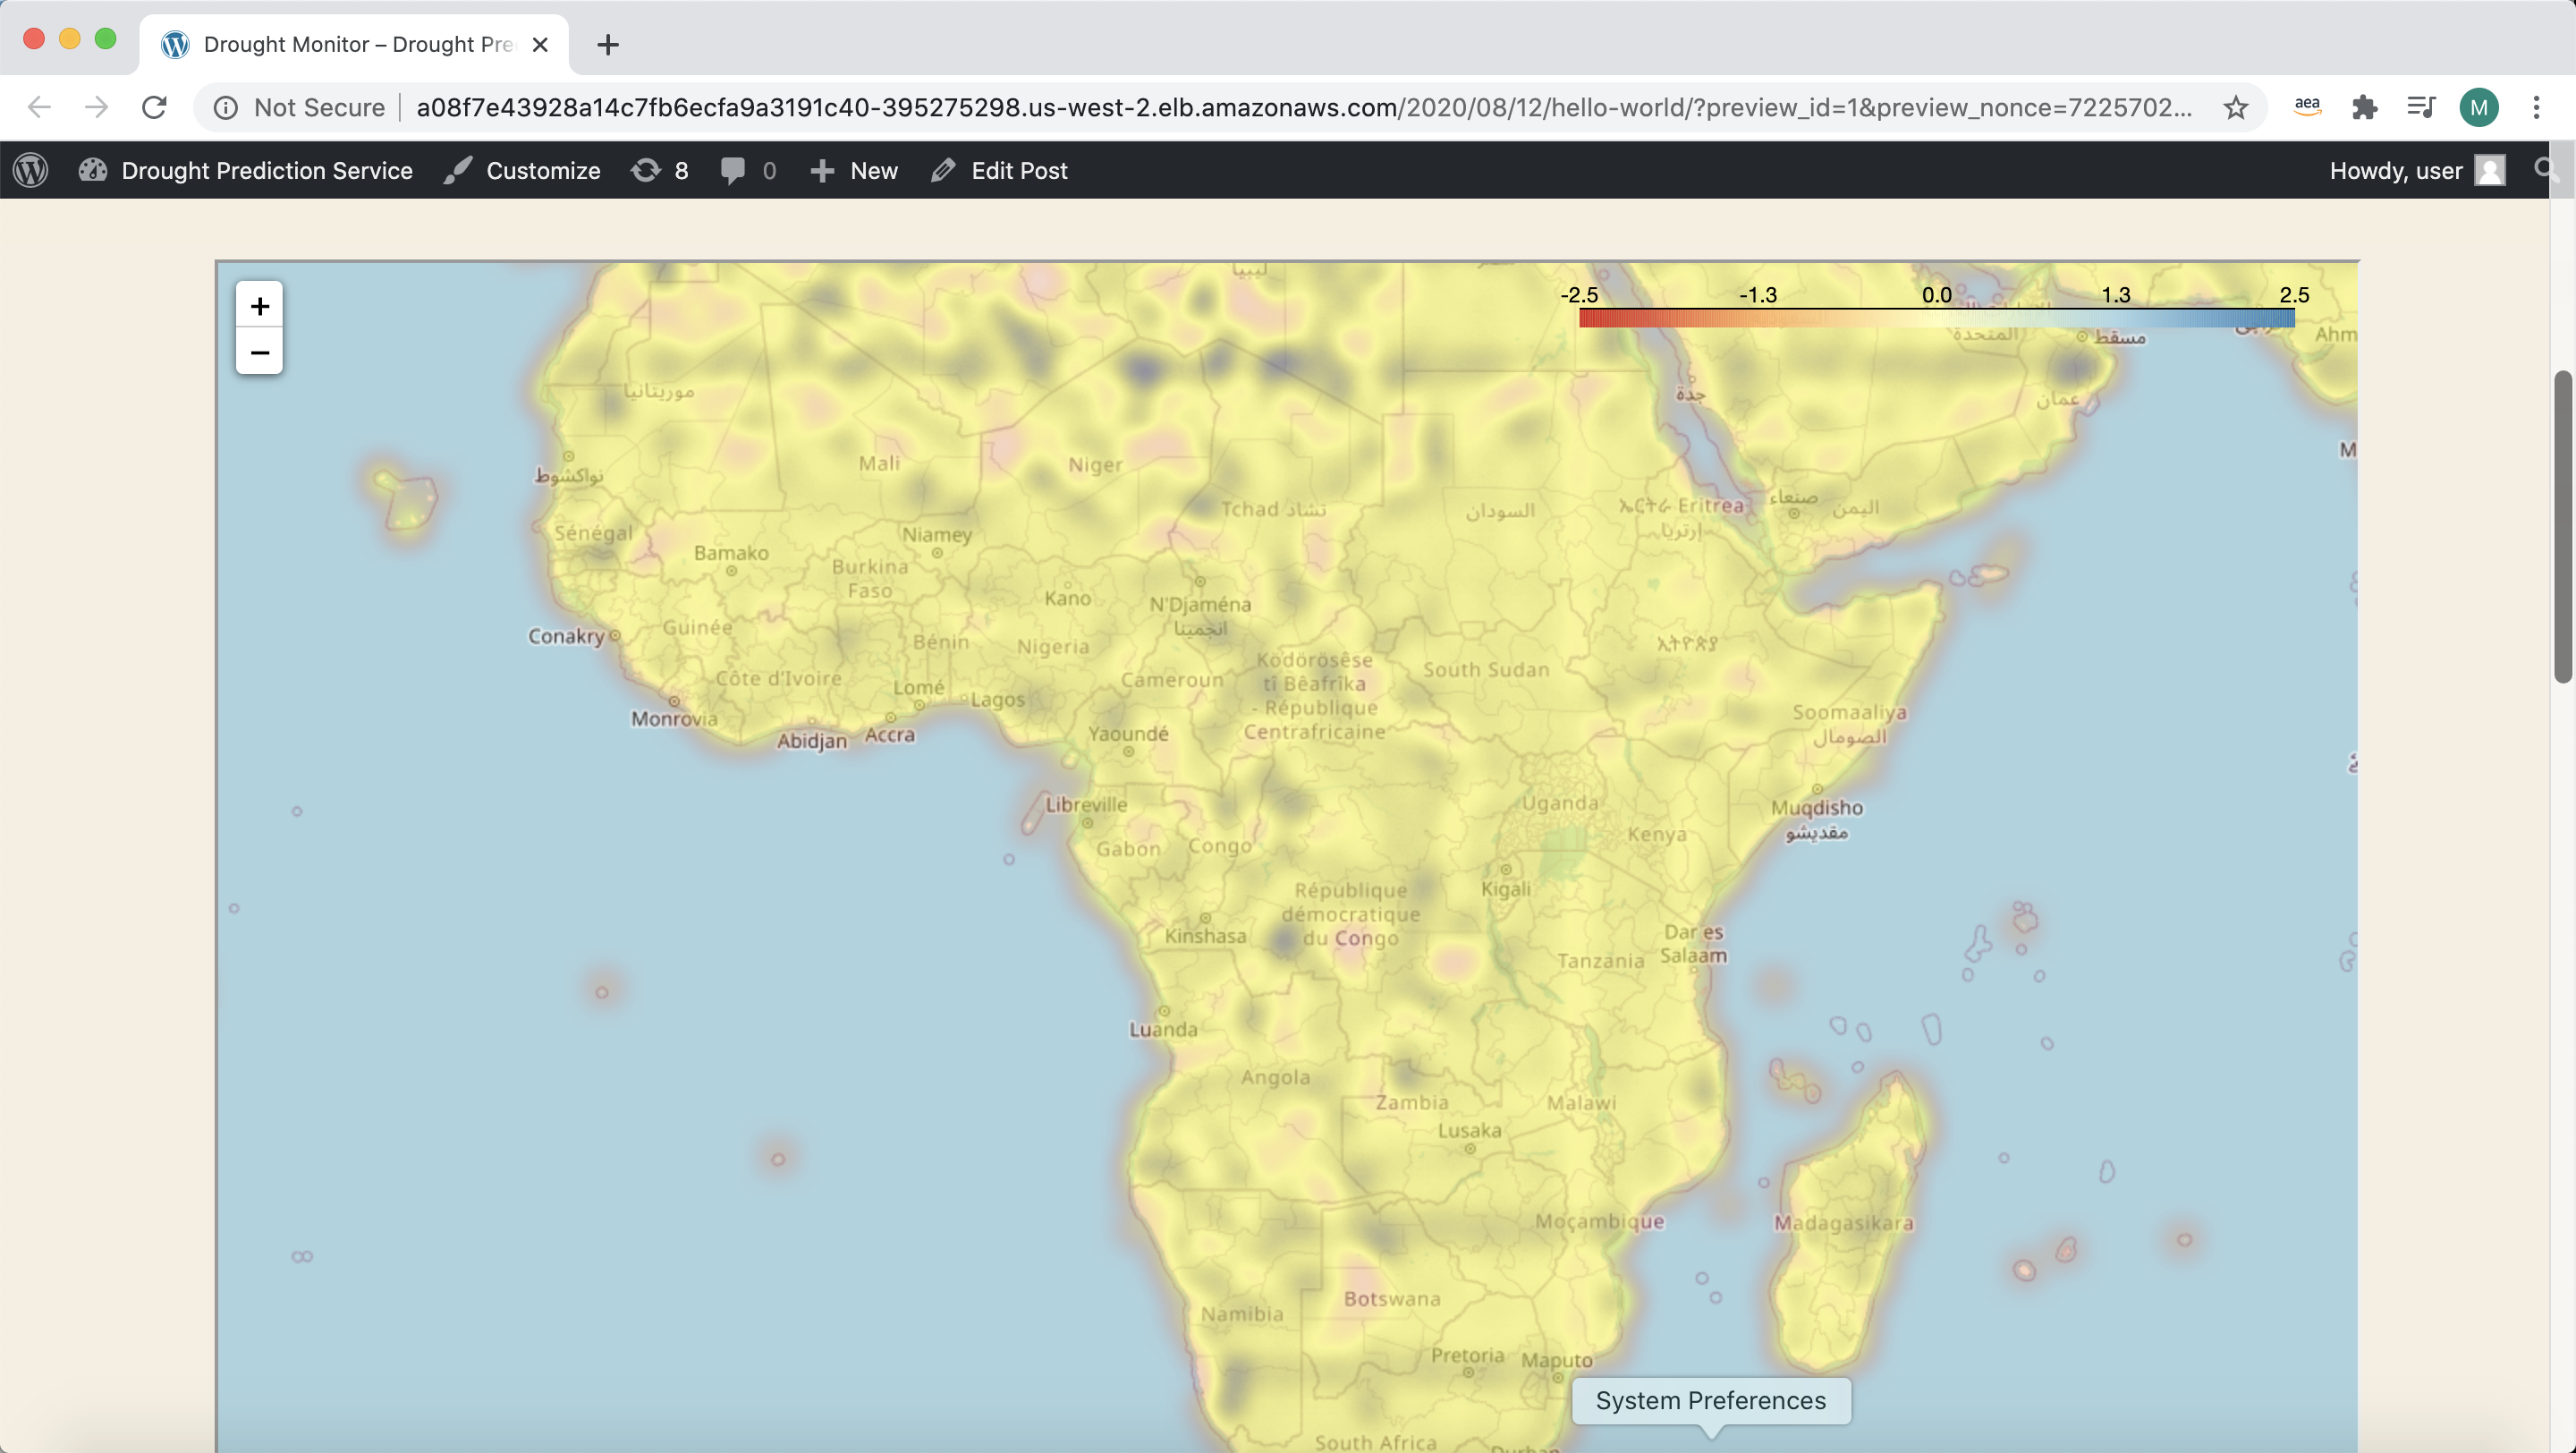


Once you have properly trained your model you will be able to use it how you want but this is just how I chose to visualize my information.

# Imports

In [10]:
## Importing relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import datetime as dt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from netCDF4 import Dataset
import xarray as xr

import sagemaker
import boto3
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

# Getting Data

The data I used for training this model was found at:

https://registry.opendata.aws/

There are many different datasets with varying levels of information however, I chose to utilize ones from NOAA (National Oceanic and Atmospheric Administration) and AFSIS (African Soil Information System)

If you would like you can choose different datasets and different features to try and improve on my results.

Here we set up our bucket name where the data is stored and find our nc file for the noaa station data

In [11]:
bucket = 'noaa-station-data'

nc_file = 's3://noaa-station-data/spei/spei01.nc'

In [12]:
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file('spei/spei01.nc', '/tmp/spei01.nc')

#we use xarray here to read in the .nc file
test = Dataset('/tmp/spei01.nc', mode='r')
ds = xr.open_dataset('/tmp/spei01.nc')

Here we create variables based on the contents of the nc file

In [13]:
lons = test.variables['lon'][:]
lats = test.variables['lat'][:]
spei = test.variables['spei'][:]
time = test.variables['time'][:]

spei_units = test.variables['spei'].units

In [18]:
#converting xarray to pandas dataframe
spei_df = ds.to_dataframe()

#dropping null values
spei_df = spei_df.dropna()

#levelling out columns
spei_df = spei_df.reset_index(level=['lat', 'lon', 'time'])

#reformatting
spei_df = spei_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
spei_df.head()

latitude  longitude       time      spei
0    -55.75     -68.25 1901-01-16  0.401407
1    -55.75     -68.25 1901-02-15 -0.242851
2    -55.75     -68.25 1901-03-16 -0.336866
3    -55.75     -68.25 1901-04-16 -0.406081
4    -55.75     -68.25 1901-05-16 -0.319509

In [20]:
#reading in from saved csv
noaa_file = 'noaa/977edd1b-f083-4b72-9711-b792db54b369.csv'
og_df = pd.read_csv(noaa_file,engine='python',encoding='utf-8',error_bad_lines=False)

og_df.head()

id  year_date element  data_value m_flag q_flag s_flag  obs_time
0  SF003242020   19930616    PRCP           0    NaN    NaN      I       NaN
1  SF003243790   19930616    PRCP           0    NaN    NaN      I       NaN
2  SF003246070   19930616    PRCP           0    NaN    NaN      I       NaN
3  SF003247250   19930616    PRCP           0    NaN    NaN      I       NaN
4  SF003254710   19930616    PRCP           0    NaN    NaN      I       NaN

In this section of code I removed the irrelevant columns as well as reformatted it to be organized by time

In [22]:
#merging data and dropping columns we dont want
noaa_df = pd.merge(og_df, df3, on='id').drop(columns=['m_flag','q_flag','s_flag','obs_time','elevation','state','name','gsn_flag','hcn_flag','wmo_id'])

#reading in from saved csv
noaa_station_file = '5f01b5b3-971b-47b6-ad36-7c9304361d9b.csv'
df3 = pd.read_csv(noaa_station_file,engine='python',encoding='utf-8',error_bad_lines=False)

noaa_df = noaa_df.rename(columns={'year_date': 'time'})
noaa_df['time'] = pd.to_datetime(noaa_df['time'])

#formating time column
noaa_df['time'] = noaa_df['time'].dt.date

#setting time column to index of our dataframe
noaa_time_test = noaa_df.set_index('time')

noaa_time_test.head()

id element  data_value  latitude  longitude
time                                                            
1970-01-01  SF003242020    PRCP           0    -28.37      24.58
1970-01-01  SF003242020    PRCP           0    -28.37      24.58
1970-01-01  SF003242020    PRCP           0    -28.37      24.58
1970-01-01  SF003242020    PRCP           0    -28.37      24.58
1970-01-01  SF003242020    PRCP           0    -28.37      24.58

In [23]:
spei_time_test = spei_df.set_index('time')
spei_time_test.head()

latitude  longitude      spei
time                                     
1901-01-16    -55.75     -68.25  0.401407
1901-02-15    -55.75     -68.25 -0.242851
1901-03-16    -55.75     -68.25 -0.336866
1901-04-16    -55.75     -68.25 -0.406081
1901-05-16    -55.75     -68.25 -0.319509

In [ ]:
noaa_spei_merged = pd.merge(spei_time_test, noaa_time_test, left_index=True, left_on=['latitude', 'longitude'],right_on=['latitude', 'longitude'])
noaa_spei_merged.head()

Here the data for the african soil information service is loaded in

In [32]:
GEOREFS_FILE = 'afsis/2009-2013/Georeferences/georeferences.csv'
georefs_df = pd.read_csv(GEOREFS_FILE)

georefs_df.head()

SSN  Public   Latitude  Longitude  Cluster  Plot Depth  \
0  icr025136    True  -6.851620  34.243313       16     7   sub   
1  icr068579    True  11.280658   8.166768        9     1   top   
2  icr048978    True -29.972100  22.710200        1     1   sub   
3  icr056481    True -16.066365  28.326498       15     1   sub   
4  icr034190    True   8.158693   9.930640       15     1   top   

                     Soil material        Scientist      Site       Country  \
0                              NaN        Tor Vagen    Itende      Tanzania   
1   Pamp.9.1.Topsoil.Std fine soil    Jerome Tondoh  Pampaida       Nigeria   
2   Prie.1.1.Subsoil.Std fine soil  George Van Zijl   Prieska  South Africa   
3  Mong.15.1.Subsoil.Std fine soil        L.T.Desta     Monga        Zambia   
4   Ibi.15.1.Topsoil.Std fine soil    Jerome Tondoh       Ibi       Nigeria   

         Region Cultivated   Gid  
0   East Africa      False   599  
1   West Africa        NaN  1487  
2  South Africa      False   786  
3  South Africa       True  1065  
4   West Africa       True   655

In [33]:
WET_CHEM_PATH = 'afsis/2009-2013/Wet_Chemistry/CROPNUTS/Wet_Chemistry_CROPNUTS.csv'

wet_chem_df = pd.read_csv(WET_CHEM_PATH, index_col='SSN')
wet_chem_df.head()

Public     EC  ExAc      ExBas   M3 Al    M3 B   M3 Ca   M3 Cu  \
SSN                                                                         
icr006475    True  0.053  2.56   2.744241  1095.0  0.3337   207.1  1.3150   
icr006586    True  0.193  0.59  16.797753  1165.0  0.7899  1665.0  2.8140   
icr007929    True  0.305  0.19  16.503619   727.6  0.6142  2518.0  0.2496   
icr008008    True  0.053  0.48   6.302775  1458.0  0.3603   734.3  1.3690   
icr010198    True  0.032  1.05   2.390303  2166.0  0.0100   261.8  1.6860   

            M3 Fe     M3 K  M3 Mg    M3 Mn  M3 Na     M3 P    M3 S  M3 Zn  \
SSN                                                                         
icr006475  153.70   306.30   89.5    9.266  42.71    4.495  18.960  2.825   
icr006586  126.80  1186.00  636.7  254.700  40.83   12.510  13.600  1.952   
icr007929  260.40    72.57  428.5   35.820  42.94   21.090  14.810  2.742   
icr008008  134.10   274.60  222.5   29.110  20.73  109.200  11.400  0.980   
icr010198   97.49    91.76   76.5  375.200  49.31    3.958   5.281  1.258   

              PH         PSI  
SSN                           
icr006475  4.682   67.052495  
icr006586  7.062   30.420552  
icr007929  7.114   60.506163  
icr008008  5.650   51.470143  
icr010198  5.501  247.626533

In [31]:
afsis_df = pd.merge(wet_chem_df, georefs_df, on='SSN').drop(columns=['Public_x','Public_y','Cluster','Plot','Depth','Soil material','Scientist','Site','Country','Region','Cultivated','Gid'])
afsis_df.head()

SSN     EC  ExAc      ExBas   M3 Al    M3 B   M3 Ca   M3 Cu   M3 Fe  \
0  icr006475  0.053  2.56   2.744241  1095.0  0.3337   207.1  1.3150  153.70   
1  icr006586  0.193  0.59  16.797753  1165.0  0.7899  1665.0  2.8140  126.80   
2  icr007929  0.305  0.19  16.503619   727.6  0.6142  2518.0  0.2496  260.40   
3  icr008008  0.053  0.48   6.302775  1458.0  0.3603   734.3  1.3690  134.10   
4  icr010198  0.032  1.05   2.390303  2166.0  0.0100   261.8  1.6860   97.49   

      M3 K  M3 Mg    M3 Mn  M3 Na     M3 P    M3 S  M3 Zn     PH         PSI  \
0   306.30   89.5    9.266  42.71    4.495  18.960  2.825  4.682   67.052495   
1  1186.00  636.7  254.700  40.83   12.510  13.600  1.952  7.062   30.420552   
2    72.57  428.5   35.820  42.94   21.090  14.810  2.742  7.114   60.506163   
3   274.60  222.5   29.110  20.73  109.200  11.400  0.980  5.650   51.470143   
4    91.76   76.5  375.200  49.31    3.958   5.281  1.258  5.501  247.626533   

    Latitude  Longitude  
0  -6.088750  36.435982  
1  -6.055750  36.457722  
2  -5.339337  37.493351  
3  -5.333700  37.515327  
4 -11.087100  35.191799

I then did some quick formatting to keep this data in line with the other data

In [ ]:
afsis_time_df = afsis_df.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})
afsis_time_df = afsis_time_df.set_index('time')
print(afsis_time_df.head())

In [ ]:
afsis_time_df = afsis_time_df.round({'latitude': 2, 'longitude': 2})
print(afsis_time_df.head())

In [ ]:
noaa_spei_merged_final = noaa_spei_merged.drop(noaa_spei_merged.tail(46430000).index,inplace=True)

In [ ]:
final_test_df = pd.merge(spei_time_test, afsis_time_df, left_index=True, left_on=['latitude', 'longitude'],right_on=['latitude', 'longitude'])
print(final_test_df.head())

In [ ]:
final_test_df = final_test_df.drop(columns=['SSN'])

This following block is not necessary however, it is helpful for learning how to visualize the spei data

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


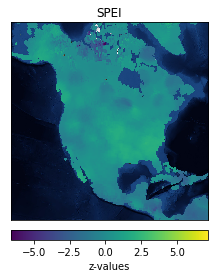

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
os.environ["PROJ_LIB"] = "/home/ec2-user/anaconda3/envs/python3/share/proj" 
from mpl_toolkits.basemap import Basemap

# Get some parameters for the Stereographic Projection
lon_0 = lons.mean()
lat_0 = lats.mean()

m = Basemap(width=8000000,height=8000000,
            resolution='l',projection='lcc',\
            lat_ts=40,lat_0=45,lon_0=-100)

# Because our lon and lat variables are 1D,
# use meshgrid to create 2D arrays
# Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

# Plot Data
cmap = mpl.cm.gist_rainbow
cs = m.pcolor(xi,yi,np.squeeze(spei[1415]))
m.bluemarble()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="5%")
cbar.set_label(spei_units)

# Add Title
plt.title('SPEI')

plt.show()

In [ ]:
nc_file = 's3://noaa-station-data/spei/spei01.nc'
s3.Bucket(bucket).download_file('spei/spei01.nc', '/tmp/spei01.nc')

test = Dataset('/tmp/spei01.nc', mode='r')

In [ ]:
! aws s3 sync s3://afsis afsis --no-sign-request

In [36]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm


bucket = 'drought-ml'
prefix = 'ml/'

m = folium.Map(location=[-3.5, 35.6], zoom_start=3)
 
for _, row in georefs_df.iterrows():
    if row[['Latitude', 'Longitude']].notnull().all():
        folium.Marker([row['Latitude'], 
                       row['Longitude']], 
                      popup=row['SSN']
                     ).add_to(m)

m


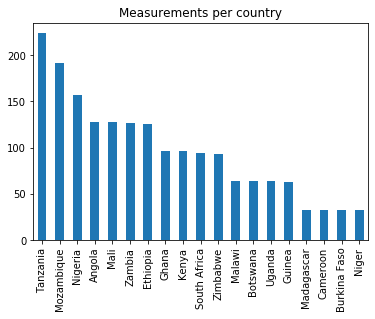

In [21]:
pd.value_counts(georefs_df['Country']).plot.bar(title='Measurements per country')

In [22]:
georefs_df.head()

SSN  Public   Latitude  Longitude  Cluster  Plot Depth  \
0  icr025136    True  -6.851620  34.243313       16     7   sub   
1  icr068579    True  11.280658   8.166768        9     1   top   
2  icr048978    True -29.972100  22.710200        1     1   sub   
3  icr056481    True -16.066365  28.326498       15     1   sub   
4  icr034190    True   8.158693   9.930640       15     1   top   

                     Soil material        Scientist      Site       Country  \
0                              NaN        Tor Vagen    Itende      Tanzania   
1   Pamp.9.1.Topsoil.Std fine soil    Jerome Tondoh  Pampaida       Nigeria   
2   Prie.1.1.Subsoil.Std fine soil  George Van Zijl   Prieska  South Africa   
3  Mong.15.1.Subsoil.Std fine soil        L.T.Desta     Monga        Zambia   
4   Ibi.15.1.Topsoil.Std fine soil    Jerome Tondoh       Ibi       Nigeria   

         Region Cultivated   Gid  
0   East Africa      False   599  
1   West Africa        NaN  1487  
2  South Africa      False   786  
3  South Africa       True  1065  
4   West Africa       True   655

# Model Training

Set up s3 variables

In [ ]:
import s3fs

bytes_to_write = data.to_csv(None).encode()
fs = s3fs.S3FileSystem()
with fs.open('s3://bucketname/foldername/data.csv', 'wb') as f:
    f.write(bytes_to_write)

In [ ]:
## Specifies the path to training and validation in S3
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [ ]:
final_test_df = final_test_df.reset_index()
print(final_test_df.head())


Set up a stratified split of our data and get it ready for training and testing


In [59]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

#performing a stratified split of the data so it is randomly shuffled and split into test and train
split = StratifiedShuffleSplit(n_splits=1, test_size=1324, random_state=100)
for train_index, test_index in split.split(final_test_df, final_test_df['spei']):
    train_set = final_test_df.loc[train_index]
    test_set = final_test_df.loc[test_index]

x_train = train_set.drop(columns=['spei'])
y_train = train_set['spei'].values.astype(float)

x_test = test_set.drop(columns=['spei'])
y_test = test_set['spei'].values.astype(float)

   level_0  index        time  latitude  longitude      spei     EC   ExAc  \
0        0      0  1970-01-01      5.25      10.25  0.066726  0.079  0.376   
1        1      1  1970-01-01      5.25      10.25  0.066726  0.077  0.432   
2        2      2  1970-01-01      5.25      10.25  0.366192  0.079  0.376   
3        3      3  1970-01-01      5.25      10.25  0.366192  0.077  0.432   
4        4      4  1970-01-01      5.25      10.25  1.028939  0.079  0.376   

      ExBas   M3 Al  ...  M3 Fe     M3 K  M3 Mg  M3 Mn  M3 Na   M3 P    M3 S  \
0  2.847301  1556.0  ...  95.00  102.491  115.5  24.87  21.88  1.734  10.341   
1  1.729125  1634.0  ...  78.46   48.701   79.9  20.32  17.88  0.791   8.227   
2  2.847301  1556.0  ...  95.00  102.491  115.5  24.87  21.88  1.734  10.341   
3  1.729125  1634.0  ...  78.46   48.701   79.9  20.32  17.88  0.791   8.227   
4  2.847301  1556.0  ...  95.00  102.491  115.5  24.87  21.88  1.734  10.341   

   M3 Zn     PH      PSI  
0  0.620  4.939  177.27

In [96]:
role = get_execution_role()            ## Run this before the training job to get your IAM role
region = boto3.Session().region_name   ## Run this here, you will need it during training
bucket = 'drought-ml'
prefix = 'ml/'

In [80]:
#setting up our training data
cols = list(train_set)
cols.insert(0, cols.pop(cols.index('spei')))
train_set = train_set.loc[:, cols]

In [97]:
#putting our train and test data into csv's for xgboost to read from s3
train_set.to_csv('train.csv', header=False, index=False)
test_set.to_csv('validation.csv', header=False, index=False)

#saving these csvs into s3 for xgboost
s3_input_train = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix + 'train/train.csv')).upload_file('train.csv')
s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join( prefix + 'validation/validation.csv')).upload_file('validation.csv')

Here we use the built in xgboost algorithm to train our model

In [102]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}validation/'.format(bucket, prefix), content_type='csv')

from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost')

role = get_execution_role() 

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket,prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=2,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}, logs=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-14 07:29:11 Starting - Starting the training job...
2020-08-14 07:29:15 Starting - Launching requested ML instances......
2020-08-14 07:30:26 Starting - Preparing the instances for training......
2020-08-14 07:31:35 Downloading - Downloading input data...
2020-08-14 07:32:00 Training - Downloading the training image..Arguments: train
[2020-08-14:07:32:21:INFO] Running standalone xgboost training.
[2020-08-14:07:32:21:INFO] File size need to be processed in the node: 0.47mb. Available memory size in the node: 8485.38mb
[2020-08-14:07:32:21:INFO] Determined delimiter of CSV input is ','
[07:32:21] S3DistributionType set as FullyReplicated
[07:32:21] 1508x22 matrix with 33176 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-14:07:32:21:INFO] Determined delimiter of CSV input is ','
[07:32:21] S3DistributionType set as FullyReplicated
[07:32:21] 1324x22 matrix with 29128 entries loaded from /opt/ml/input/data/validation?format=csv&label_co

After our model is trained it is time to perform hyperparameter tuning

You can vary the values used here as you see fit and play around with different variables to try and improve the results.

In [107]:
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=2,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        num_round=100,
                        eval_metric='rmse')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-14 12:14:31 Starting - Starting the training job...
2020-08-14 12:14:33 Starting - Launching requested ML instances.........
2020-08-14 12:16:16 Starting - Preparing the instances for training............
2020-08-14 12:18:19 Downloading - Downloading input data
2020-08-14 12:18:19 Training - Downloading the training image..Arguments: train
[2020-08-14:12:18:39:INFO] Running standalone xgboost training.
[2020-08-14:12:18:39:INFO] File size need to be processed in the node: 0.47mb. Available memory size in the node: 8496.82mb
[2020-08-14:12:18:39:INFO] Determined delimiter of CSV input is ','
[12:18:39] S3DistributionType set as FullyReplicated
[12:18:39] 1508x22 matrix with 33176 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-14:12:18:39:INFO] Determined delimiter of CSV input is ','
[12:18:39] S3DistributionType set as FullyReplicated
[12:18:39] 1324x22 matrix with 29128 entries loaded from /opt/ml/input/data/validation?format=csv&la

Congratulations! Now you have a trained model ready to use how you see fit. 

My final RMSE was 1.616 however, depending on the values you chose for hyperparameters and if you changed the data used you could perform much better!